In [1]:
from scipy.sparse.linalg import spsolve
from scipy.sparse import csc_matrix
from scipy.sparse import diags
import scipy.sparse as sparse
import scipy.linalg as linalg
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

cond Z =  158943.20166220682
monolithic error = 6.716006801816265e-14


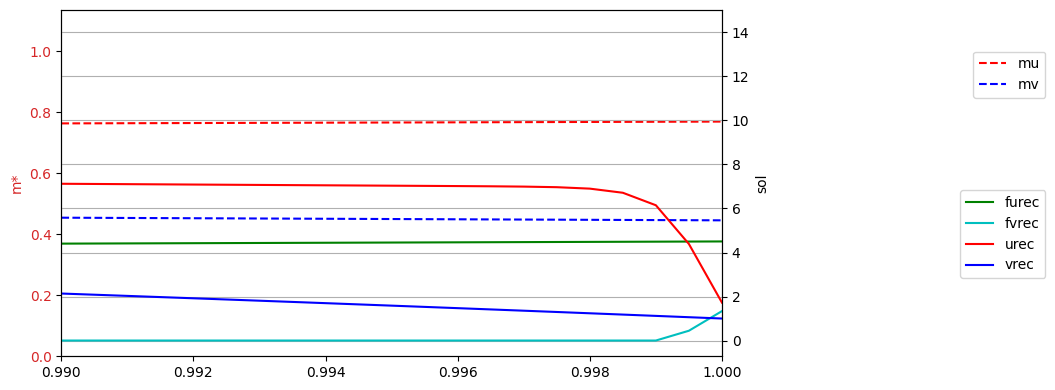

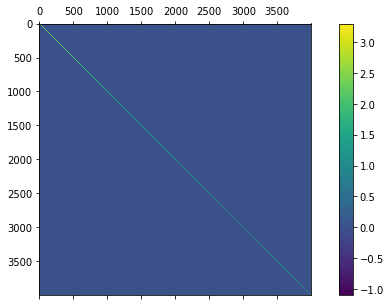

In [6]:
def mu(x):
    return 0.9  + 0.2*np.cos(4*x)

def mv(x):
    return 0.5 + 0.1*np.sin(10*x)

def reconstruct(sol, x):
    n = len(sol)
    rec = 0.0*x
    for i, val in enumerate(x):
        if i == 0:
            rec[0] = 1.5*sol[0] - 0.5*sol[1]
        elif i==len(x)-1:
            rec[i] = 1.5*sol[-1] - 0.5*sol[-2]
        else:
            rec[i] = 0.5*(sol[i-1]+sol[i])
    return rec

beta = 100.0

left_condition_type_u = 'dirichlet'
left_condition_value_u = 0.0
right_condition_type_u = 'dirichlet'
right_condition_value_u = 0.0

left_condition_type_v = 'neumann'
left_condition_value_v = 0.0
right_condition_type_v = 'dirichlet' 
right_condition_value_v = 1.0

N = 2000 #grid cells
L = 1.0 #interval
dx = np.divide(L,N)
x = np.linspace(0,L,N+1)
xc = np.linspace(0.5*dx,L-0.5*dx,N)

def diag(k, m, left_condition_type, right_condition_type):
    tmp = 0.0
    if k==0:
        if left_condition_type=='dirichlet':
            tmp = np.square(dx)*beta + m(dx) + 2.0*m(0.0)
        elif left_condition_type=='neumann':
            tmp = np.square(dx)*beta + m(dx)
    elif k==N-1:
        if right_condition_type=='dirichlet':
            tmp = np.square(dx)*beta + 2.0*m(L) + m(L-dx)
        elif right_condition_type=='neumann':
            tmp = np.square(dx)*beta + m(L-dx)
    else:
        tmp = np.square(dx)*beta + m((k+1)*dx) + m(k*dx)
    return tmp

def upper(k, m, left_condition_type, right_condition_type):
    if k==0:
        return -m(dx)
    else:
        return -mv(dx*(1+k))

def lower(k, m, left_condition_type, right_condition_type):
    if k==N-1:
        return -m(L-dx)
    else:
        return -m(dx*k)

def source_u():
    # np.zeros(N)
    tmp = np.linspace(0, 1.0, N)
    return 2.0 + 10*(tmp-0.5)**2

def source_v():
    return np.zeros(N)

def known_term(source, m, left_condition_type, left_condition_value, right_condition_type, right_condition_value):
    tmp = source
    if left_condition_type=='dirichlet':
        tmp[0] = tmp[0] + 2.0*m(0.0)*left_condition_value
    elif left_condition_type=='neumann':
        tmp[0] = tmp[0] - m(0.0)*dx*left_condition_value
    if right_condition_type=='dirichlet':
        tmp[N-1] = tmp[N-1] + 2.0*m(L)*right_condition_value
    elif right_condition_type=='neumann':
        tmp[N-1] = tmp[N-1] + m(L)*dx*right_condition_value
    return tmp

diagA = np.zeros(N)
upperA = np.zeros(N-1)
lowerA = np.zeros(N-1)
diagD = np.zeros(N)
upperD = np.zeros(N-1)
lowerD = np.zeros(N-1)

for k in range(N):
    diagA[k] = diag(k, mu, left_condition_type_u, right_condition_type_u)
    diagD[k] = diag(k, mv, left_condition_type_v, right_condition_type_v)

for k in range(N-1):
    upperA[k] = upper(k, mu, left_condition_type_u, right_condition_type_u)
    lowerA[k] = upper(k, mu, left_condition_type_u, right_condition_type_u)
    upperD[k] = upper(k, mv, left_condition_type_v, right_condition_type_v)
    lowerD[k] = upper(k, mv, left_condition_type_v, right_condition_type_v)

A = diags([diagA, upperA, lowerA], [0, -1, 1])
D = diags([diagD, upperD, lowerD], [0, -1, 1])
B = -np.square(dx)*beta*sparse.eye(N)
C = -np.square(dx)*beta*sparse.eye(N)

Z = np.zeros((2*N,2*N))
Z[:N,:N] = A.toarray()
Z[:N,N:] = B.toarray()
Z[N:,:N] = C.toarray()
Z[N:,N:] = D.toarray()


fu = np.zeros(N)
fu = known_term(source_u(), mu, left_condition_type_u, left_condition_value_u, right_condition_type_u, right_condition_value_u)

fv = np.zeros(N)
fv = known_term(source_v(), mv, left_condition_type_v, left_condition_value_v, right_condition_type_v, right_condition_value_v)

print('start computation')
f = np.concatenate((fu,fv))
sol = linalg.solve(Z, f)
u = sol[:N]
v = sol[N:]

print("cond Z = ", np.linalg.cond(Z))
print(f"monolithic error = {np.linalg.norm(f-np.dot(Z,sol))}")

fig, ax1 = plt.subplots(figsize=(12,4), dpi=100)
color = 'tab:red'
ax1.set_xlabel('')
ax1.set_ylabel('m*', color=color)
ax1.plot(x, mu(x), '--r', label='mu')
ax1.plot(x, mv(x), '--b', label='mv')
#ax1.plot(x, 0*x, '.', color='k', label='faces', markersize=10.0)
#ax1.plot(xc, 0*xc, 'x', color='k', label='cell centers')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(bbox_to_anchor=(1.5, 0.9))
ax1.set_ylim(bottom=0.0)
markersize = 15
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('f*', color=color)  # we already handled the x-label with ax1
#ax2.plot(xc, fu, 'g_', label='fu', markersize=markersize)
#ax2.plot(xc, fv, 'c_', label='fv', markersize=markersize)
ax2.plot(x, reconstruct(fu, x), '-g' , label='furec')
ax2.plot(x, reconstruct(fv, x), '-c' , label='fvrec')
ax2.tick_params(axis='y', labelcolor=color)
color = 'k'
ax2.set_ylabel('sol', color=color)  # we already handled the x-label with ax1
#ax2.plot(xc, u, '_r' , label='u', markersize=markersize)
ax2.plot(x, reconstruct(u, x), '-r' , label='urec')
#ax2.plot(xc, v, '_b' , label='v', markersize=markersize)
ax2.plot(x, reconstruct(v, x), '-b' , label='vrec')
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(bbox_to_anchor=(1.5, 0.5))
ax2.set_xlim([0.99,1])

fig.tight_layout()
plt.grid(axis='both', which='both')
plt.show()

fig1, ax = plt.subplots(1, 1, figsize=(10,5))
cax = ax.matshow(Z)
fig1.colorbar(cax, ax=ax)
plt.savefig('matrix.pdf')